# Neural Networks on MNIST

This Jupyter notebook explains various approaches for implementing neural networks that recognize digits on [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

## 0 Preparing the MNIST dataset

Most deep learning frameworks provide APIs for loading famous datasets like MNIST (e.g., `torchvision.datasets.MNIST` in pytorch). The APIs are handy, but hide the important step for preparing a training data for a deep learning framework; when graduating from an example dataset to the real data, we must convert a training data of our interest into the data structure that is acceptable by a deep learning framework.

The cell below downloads the original distribution of the MNIST dataset on the Web, converts the dataset into `numpy` arrays, and saves the arrays as the file `mnist.npz` with keyword names.

### 0.1 Download the dataset

In [1]:
import gzip
import os
import sys
import struct
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

os.system('wget -N https://raw.githubusercontent.com/LaFabrickMassy/Projet-Fablab/main/Miditech/ML/train-images-idx3-ubyte.gz -O train-images-idx3-ubyte.gz')
os.system('wget -N https://raw.githubusercontent.com/LaFabrickMassy/Projet-Fablab/main/Miditech/ML/train-labels-idx1-ubyte.gz -O train-labels-idx1-ubyte.gz')
os.system('wget -N https://raw.githubusercontent.com/LaFabrickMassy/Projet-Fablab/main/Miditech/ML/t10k-images-idx3-ubyte.gz -O t10k-images-idx3-ubyte.gz')
os.system('wget -N https://raw.githubusercontent.com/LaFabrickMassy/Projet-Fablab/main/Miditech/ML/t10k-labels-idx1-ubyte.gz -O t10k-labels-idx1-ubyte.gz')

train_x=read_image(gzip.open('train-images-idx3-ubyte.gz', 'rb'))
train_y=read_label(gzip.open('train-labels-idx1-ubyte.gz', 'rb'))
test_x=read_image(gzip.open('t10k-images-idx3-ubyte.gz', 'rb'))
test_y=read_label(gzip.open('t10k-labels-idx1-ubyte.gz', 'rb'))

np.savez_compressed(
    'mnist',
    train_x = train_x,
    train_y = train_y,
    test_x = test_x,
    test_y = test_y)

data = np.load('mnist.npz')

The file contains four numpy arrays (one tensor and array for each split of training and test sets) with the keywords:

+ `train_x`: $60000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `train_y`: $60000 \text{ (labels)}$
+ `test_x`: $10000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `test_y`: $10000 \text{ (labels)}$


### 0.2 Have a look to the dataset structure

In [2]:

print(data)

print(data['train_x'].shape, data['train_x'].dtype)
print(data['train_y'].shape, data['train_y'].dtype)
print(data['test_x'].shape, data['test_x'].dtype)
print(data['test_y'].shape, data['test_y'].dtype)

NpzFile 'mnist.npz' with keys: train_x, train_y, test_x, test_y
(60000, 28, 28) float32
(60000,) uint8
(10000, 28, 28) float32
(10000,) uint8


### 0.3 Visualize the dataset

5


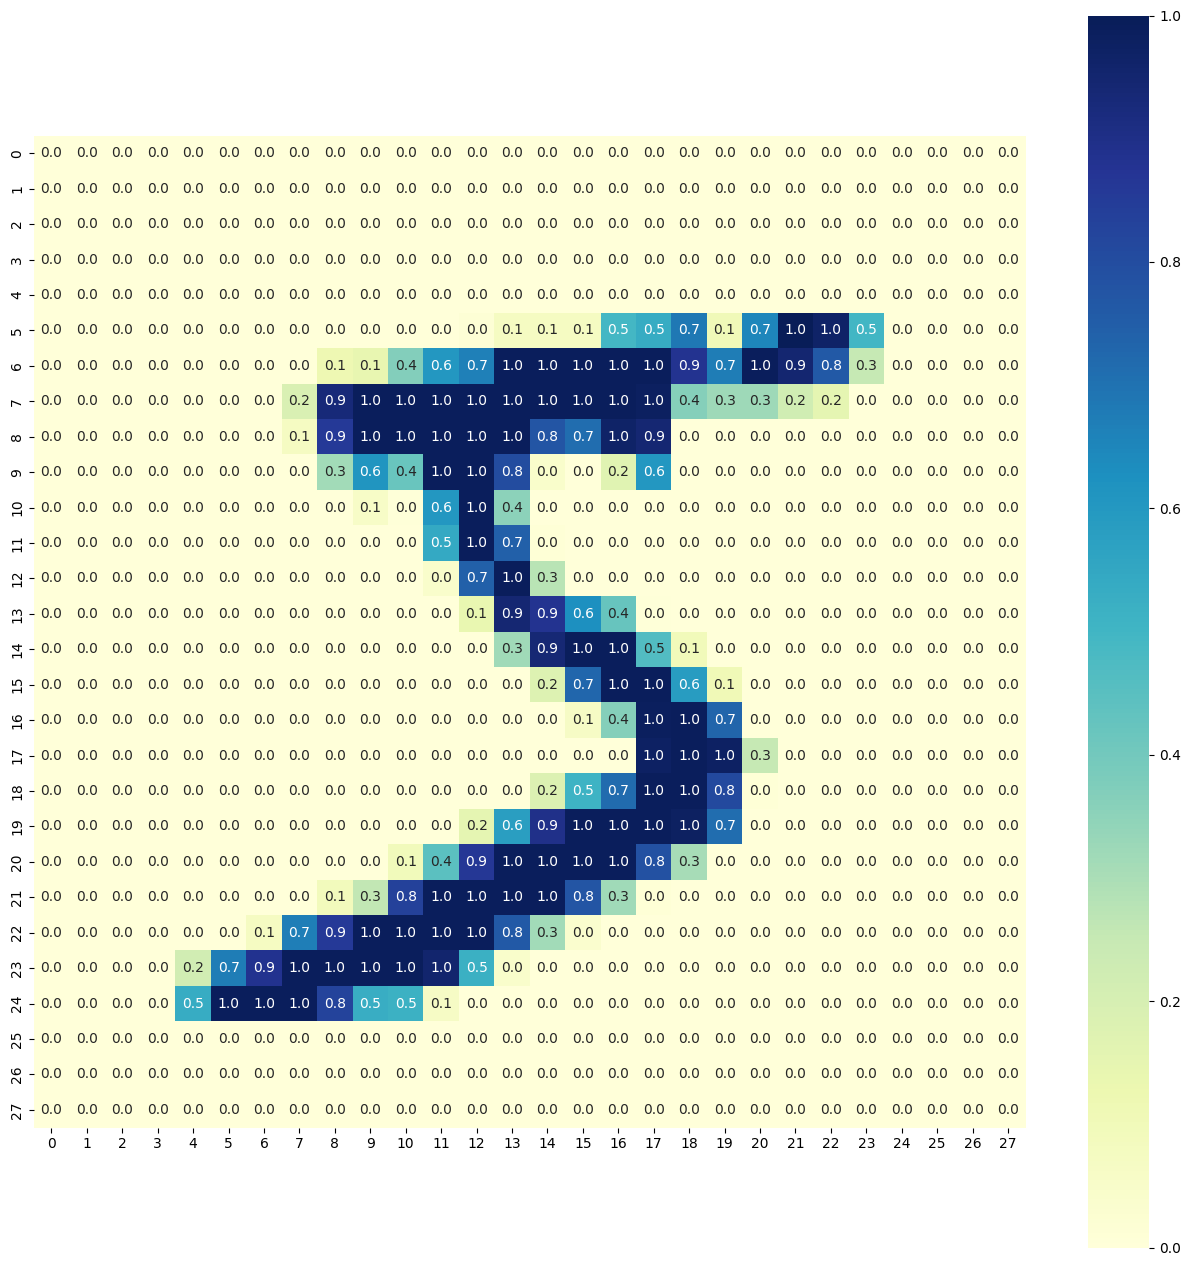

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Index number of an instance (change this to view another instance).
i = 0

data = np.load('mnist.npz')
image = data['train_x'][i]
label = data['train_y'][i]

print(label)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

### 0.4 Install a library for plotting loss and accuracy values

In [4]:
!pip install livelossplot
!pip install torch torchvision

## 1 Training without dedicated library

### 1.1 Perceptron algorithm for single-layer neural network

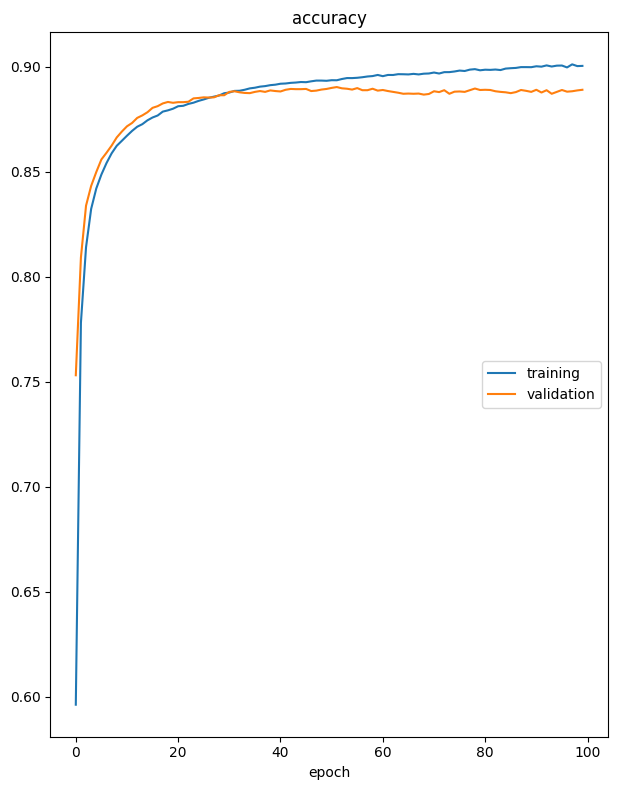

accuracy
	training         	 (min:    0.596, max:    0.901, cur:    0.900)
	validation       	 (min:    0.753, max:    0.890, cur:    0.889)
Accuracy: 0.8891 (test), 0.9005 (train)


In [29]:
import numpy as np
from livelossplot import PlotLosses

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))     # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]    # Append 1: (N x 784) -> (N x 785)

data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])
Ytrain = data['train_y']
Xtest = image_to_vector(data['test_x'])
Ytest = data['test_y']

W = np.random.randn(10, 28*28+1)

eta = 0.001
liveloss = PlotLosses()
for t in range(100):
    # Structured perceptron for updating weights.
    num_correct_train = 0
    for x, y in zip(Xtrain, Ytrain):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred != y:
            W[y] += x * eta
            W[y_pred] -= x * eta
        else:
            num_correct_train += 1

    # Evaluate and store the accuracy on the test set.
    num_correct_test = 0
    for x, y in zip(Xtest, Ytest):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred == y:
            num_correct_test += 1

    # Visualize accuracy values on the training and test sets.
    liveloss.update({
        'accuracy': float(num_correct_train) / len(Ytrain),
        'val_accuracy': float(num_correct_test) / len(Ytest)
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(
    float(num_correct_test) / len(Ytest),
    float(num_correct_train) / len(Ytrain)
    ))

### 1.2 Stochastic gradient descent for single-layer neural network

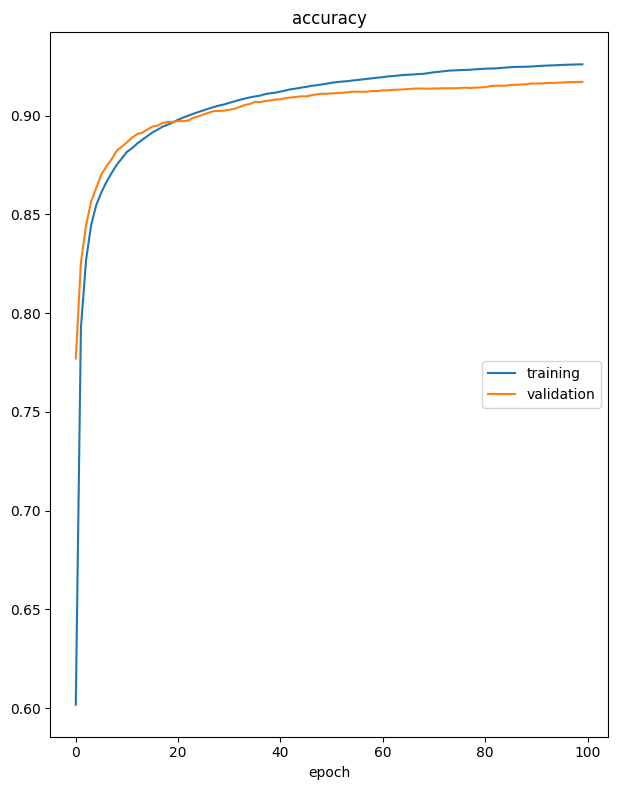

accuracy
	training         	 (min:    0.602, max:    0.926, cur:    0.926)
	validation       	 (min:    0.777, max:    0.917, cur:    0.917)
Accuracy: 0.9170 (test), 0.9259 (train)


In [30]:
import numpy as np
from livelossplot import PlotLosses

def softmax(x):
    # Result of softmax are invariant even if we add/subtract a constant.
    ex = np.exp(x - np.max(x))  # Subtract such that the maximum value is one.
    return ex / ex.sum(axis=0)

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))     # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]    # Append 1: (N x 784) -> (N x 785)

def label_to_onehot(Y, K):
    return np.eye(K)[Y]              # e.g., 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0]

data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])
Ytrain = label_to_onehot(data['train_y'], 10)
Xtest = image_to_vector(data['test_x'])
Ytest = data['test_y']

W = np.random.randn(10, 28*28+1)

eta = 0.001
liveloss = PlotLosses()
for t in range(100):
    num_correct_train = 0

    # Stochastic gradient descent.
    for x, y in zip(Xtrain, Ytrain):
        y_pred = softmax(np.dot(W, x))
        W += np.outer(eta * (y - y_pred), x)
        if  np.argmax(y_pred) == np.argmax(y):
            num_correct_train += 1

    # Evaluate and store the accuracy on the test set.
    num_correct_test = 0
    for x, y in zip(Xtest, Ytest):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred == y:
            num_correct_test += 1

    # Visualize accuracy values on the training and test sets.
    liveloss.update({
        'accuracy': float(num_correct_train) / len(Ytrain),
        'val_accuracy': float(num_correct_test) / len(Ytest)
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(
    float(num_correct_test) / len(Ytest),
    float(num_correct_train) / len(Ytrain)
    ))

## 2 Training with pytorch

### 2.0 Create useful functions

In [5]:
def create_dataset(x, y, flatten=False):
    if flatten:
        # Convert it into a matrix (N [samples], 28*28 [dims])
        xt = torch.from_numpy(x).view(len(x), -1)
    else:
        # Convert it into a 4D tensor (N [samples], 1 [ch], 28 [px], 28 [px])
        xt = torch.from_numpy(x).unsqueeze(1)
    yt = torch.from_numpy(y).long()
    return TensorDataset(xt, yt)

def test_model(model, loss_fn, test_loader, device):
    model.eval()

    loss = 0.
    num_correct = 0.
    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss += loss_fn(y_pred, y).item()
        _, predicted = torch.max(y_pred.data, 1)
        num_correct += (predicted == y).sum().item()

    model.train()
    loss /= len(test_loader.dataset)
    num_correct /= len(test_loader.dataset)
    return loss, num_correct

### 2.1 Single-layer neural network




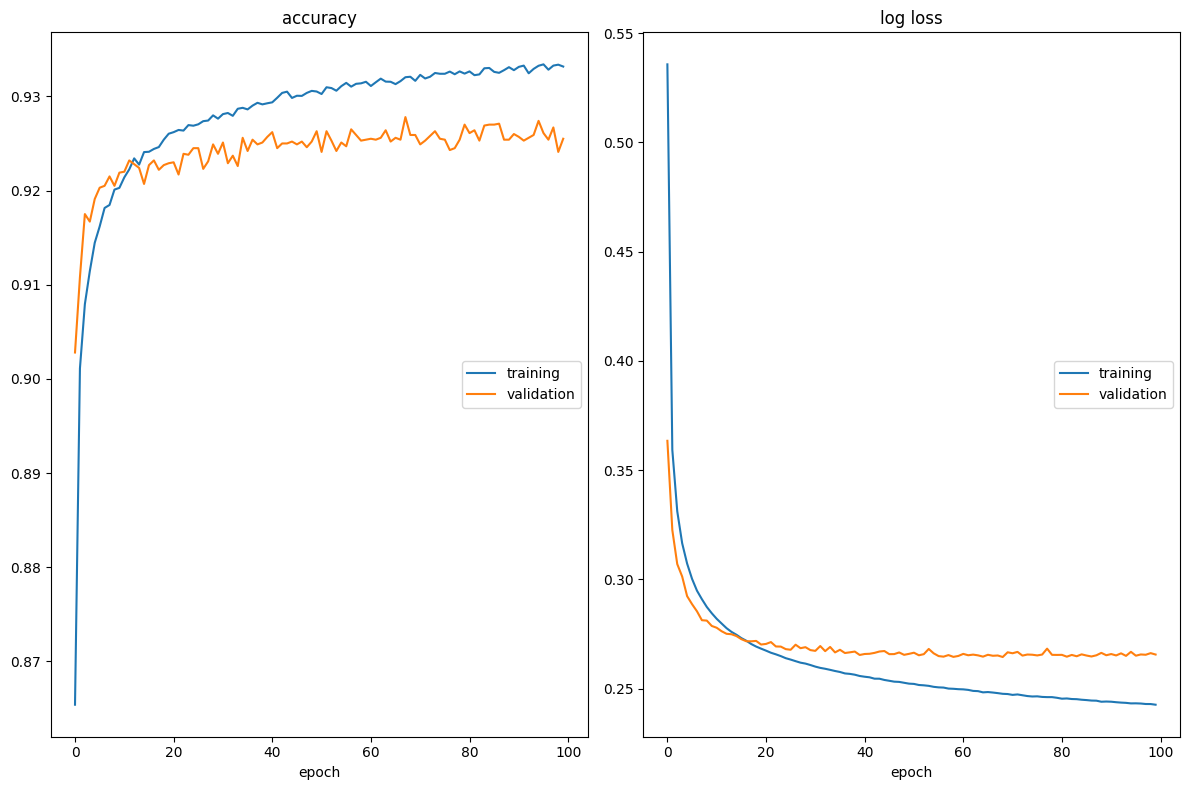

accuracy
	training         	 (min:    0.865, max:    0.933, cur:    0.933)
	validation       	 (min:    0.903, max:    0.928, cur:    0.925)
log loss
	training         	 (min:    0.243, max:    0.536, cur:    0.243)
	validation       	 (min:    0.264, max:    0.363, cur:    0.266)
Accuracy: 0.9255 (test), 0.9332 (train)


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses

#device = torch.device("cpu") # Uncomment this to run on CPU
device = torch.device("cuda:0") # Uncomment this to run on GPU

model = nn.Sequential()
model.add_module('fc1', nn.Linear(784, 10, bias=True))
print(model)
model.to(device)

def create_dataset(x, y):
    xt = torch.from_numpy(x).view(len(x), -1)
    yt = torch.from_numpy(y).long()
    return TensorDataset(xt, yt)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'])
test_set = create_dataset(data['test_x'], data['test_y'])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(100):
    train_loss = 0.
    train_correct = 0

    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()

        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))

    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))

### 2.2 Three-layer neural network

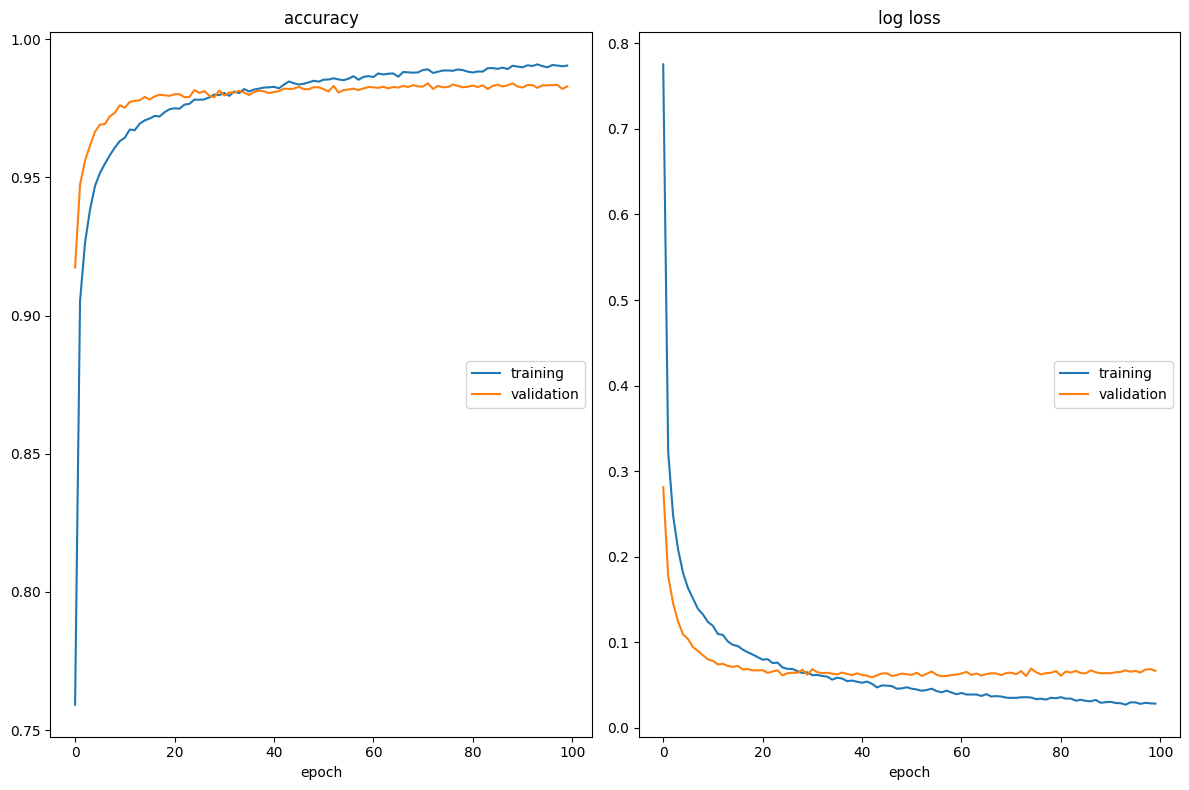

accuracy
	training         	 (min:    0.759, max:    0.991, cur:    0.990)
	validation       	 (min:    0.917, max:    0.984, cur:    0.983)
log loss
	training         	 (min:    0.027, max:    0.775, cur:    0.028)
	validation       	 (min:    0.059, max:    0.281, cur:    0.067)
Accuracy: 0.9829 (test), 0.9905 (train)


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses

#device = torch.device("cpu") # Uncomment this to run on CPU
device = torch.device("cuda:0") # Uncomment this to run on GPU

model = nn.Sequential()
model.add_module('fc1',      nn.Linear(784, 256))
model.add_module('relu1',    nn.ReLU())
model.add_module('dropout1', nn.Dropout())
model.add_module('fc2',      nn.Linear(256, 256))
model.add_module('relu2',    nn.ReLU())
model.add_module('dropout2', nn.Dropout())
model.add_module('fc3',      nn.Linear(256, 10))
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'])
test_set = create_dataset(data['test_x'], data['test_y'])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(100):
    train_loss = 0.
    train_correct = 0

    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()

        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))

    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))

### 2.3 Convolutional Neural Network (CNN)

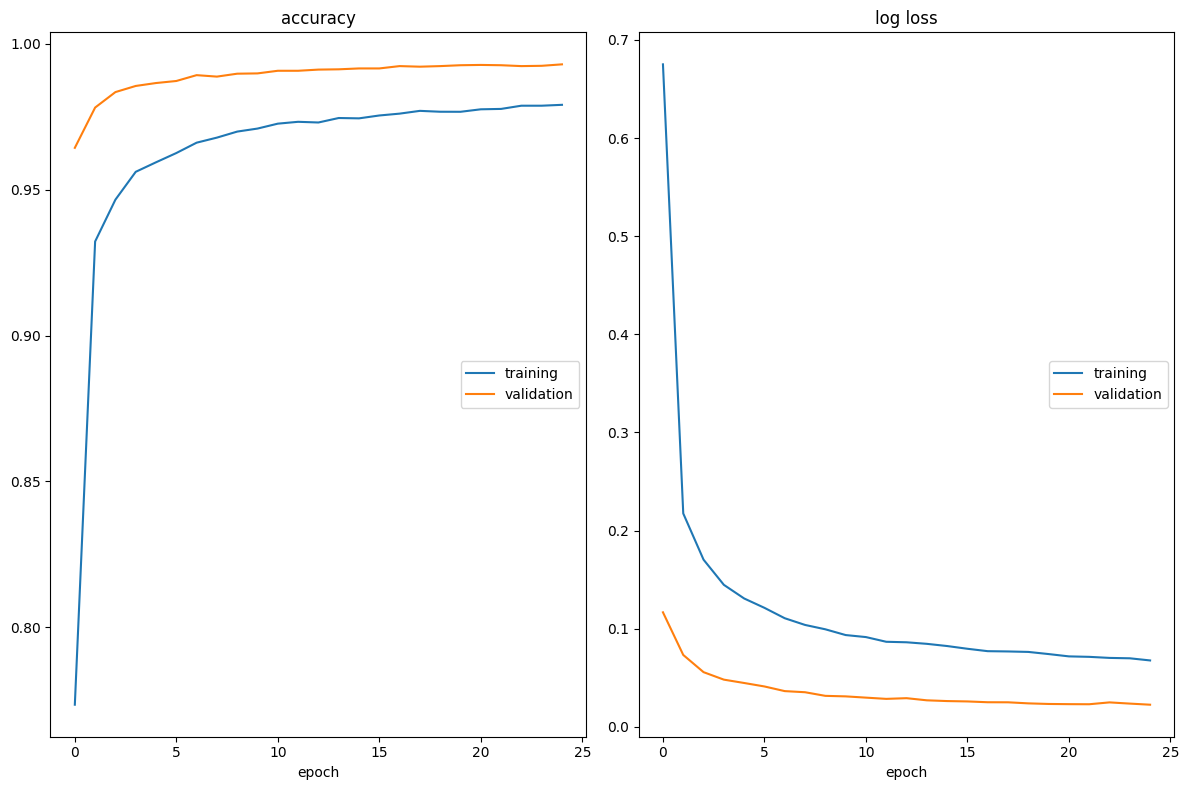

accuracy
	training         	 (min:    0.774, max:    0.979, cur:    0.979)
	validation       	 (min:    0.964, max:    0.993, cur:    0.993)
log loss
	training         	 (min:    0.068, max:    0.675, cur:    0.068)
	validation       	 (min:    0.023, max:    0.117, cur:    0.023)
Accuracy: 0.9929 (test), 0.9790 (train)


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses

# check if run with GPU
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  nb_epoch = 100
else:
  device = torch.device("cpu")
  nb_epoch = 10


class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(-1, 512)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, (5, 5)),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Conv2d(16, 32, (5, 5)),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    Flatten(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(256, 10),
)
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'])
test_set = create_dataset(data['test_x'], data['test_y'])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()

for t in range(nb_epoch):
    train_loss = 0.
    train_correct = 0

    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()

        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))

    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))

[]


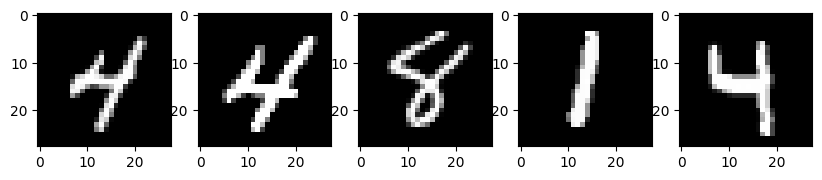

0:    0.08%     0.06%     0.52%    45.45%     0.88% 
1:   11.00%    99.94%     0.23%   100.00%    64.10% 
2:   99.61%    44.17%    42.68%    99.05%    35.00% 
3:    0.09%     0.00%    97.33%     0.03%     1.43% 
4:  100.00%   100.00%    25.51%    69.23%    99.99% 
5:   35.94%     0.00%    60.14%     3.79%    62.79% 
6:    4.52%    84.18%     4.14%     2.38%    33.51% 
7:   94.72%     1.47%     1.28%    60.05%    37.46% 
8:    0.57%    16.64%   100.00%     7.87%    89.99% 
9:    0.96%    30.64%    99.17%     0.11%    29.80% 


In [12]:
nb_img = 5
import random
random.seed()

fig = plt.figure(figsize=(10, 10*nb_img))
probas = [] # will be a list of list of probas per number and per image
print(probas)
for i in range(nb_img):
  # pick a random image
  x = data['test_x'][random.randint(0, len(data['test_x']))]
  # sho image
  first_image = np.array(x, dtype='float')
  pixels = first_image.reshape((28, 28))
  fig.add_subplot(1, nb_img, i+1)
  plt.imshow(pixels, cmap='gray')
  # evaluate model on the image
  x = torch.from_numpy(x).unsqueeze(0).float().to(device) # always have to convert data format !
  t = model(x) # evaluate
  t = torch.sigmoid(t) # we want probabilities
  t = t.cpu().detach().numpy().reshape(10).tolist()  # always have to convert data format !
  probas.append(t)

plt.show() # show all images on a line
for j in range(10):
  print("{:d}:".format(j), end = "")
  for i in range(nb_img):
    p = probas[i][j]*100.
    print("{:8.2f}% ".format(p), end="")
  print("")
